# Natural Language Processing with Disaster Tweets

The goal of this project is to build a model that classifies the text in tweets as either referring to an actual disaster or not.

This project was developed as a submission to the [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data).


## Setup

In [26]:
# @title Install Dependencies

!pip install jupyter-black
!pip install wordcloud matplotlib
!pip install scikit-learn
!pip install keras-tuner
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-24 18:05:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-24 18:05:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-24 18:05:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
import kagglehub

kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
dataset_path = kagglehub.competition_download("nlp-getting-started")

print(f"dataset_path #{dataset_path}")

100%|██████████| 593k/593k [00:00<00:00, 83.1MB/s]

Extracting files...
dataset_path #/root/.cache/kagglehub/competitions/nlp-getting-started


In [5]:
import pandas as pd

train_df = pd.read_csv(dataset_path + "/train.csv")
test_df = pd.read_csv(dataset_path + "/test.csv")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## References

> **Citation for Kaggle Competition**  
Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. *Natural Language Processing with Disaster Tweets*. [Kaggle](https://kaggle.com/competitions/nlp-getting-started), 2019.

> **Citation for dataset**  
The original dataset is no longer publicly available. Kaggle refers to the following source for similar data:  
[https://www.appen.com/data-for-everyone](https://www.appen.com/data-for-everyone)

## Problem Analysis

The dataset consists of tweets, each with accompanying text, keyword, and location information. The task is a binary classification problem: determine whether a tweet is referring to a real disaster (`target = 1`) or not (`target = 0`).

Let's explore the data to understand its shape, size, and overall condition:

In [6]:
number_of_tweets = len(train_df)
number_of_test_tweets = len(test_df)
missing_values = train_df.isnull().sum()

print(f"Number of tweets in training set:\n{number_of_tweets}\n")
print(f"Number of tweets in test set:\n{number_of_test_tweets}\n")
print(f"Missing values:\n{missing_values}")

Number of tweets in training set:
7613

Number of tweets in test set:
3263

Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [7]:
average_length = train_df["text"].str.len().mean()
median_length = train_df["text"].str.len().median()
max_length = train_df["text"].str.len().max()
min_length = train_df["text"].str.len().min()

print(f"Average length of tweets:\n{average_length}\n")
print(f"Median length of tweets:\n{median_length}\n")
print(f"Max length of tweets:\n{max_length}\n")
print(f"Min length of tweets:\n{min_length}")

Average length of tweets:
101.03743596479706

Median length of tweets:
107.0

Max length of tweets:
157

Min length of tweets:
7


In [8]:
number_of_locations = train_df["location"].nunique()
number_of_keywords = train_df["keyword"].nunique()

print(f"Number of locations:\n{number_of_locations}\n")
print(f"Number of keywords:\n{number_of_keywords}")

Number of locations:
3341

Number of keywords:
221


## EDA

From the initial overview, we observe that the dataset includes missing values in both the `location` and `keyword` fields. It appears that most of the useful information will come from the tweet text itself, which contains an average of 107 words and a median of 101 words.

We'll start by focusing on understanding the content of the text. Later, we could evaluate whether incorporating `location` and `keyword` adds value to the model.

Since we are working with text data, it will be beneficial to convert all text to lowercase and clean it by removing punctuation and stop words. This helps standardize the input and ensures we're working with the meaningful content of each tweet.

In [9]:
import re
import nltk
from nltk.corpus import stopwords
import string

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# in EDA I also discovered links became an issue
stop_words.add("https")
stop_words.add("co")
stop_words.add("http")
stop_words.add("amp")
stop_words.add("www")
stop_words.add("û")
stop_words.add("com")


def clean_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text


train_df["cleaned_text"] = train_df["text"].apply(clean_text)
print(train_df[["text", "cleaned_text"]].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  got sent photo ruby alaska smoke wildfires pou...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


If we look at the length of tweets split by target, we observe that there are more non-disaster tweets than disaster tweets. Additionally, tweets labeled as disasters tend to have a longer length distribution on average.

Number of disaster tweets: 3271
Number of non-disaster tweets: 4342


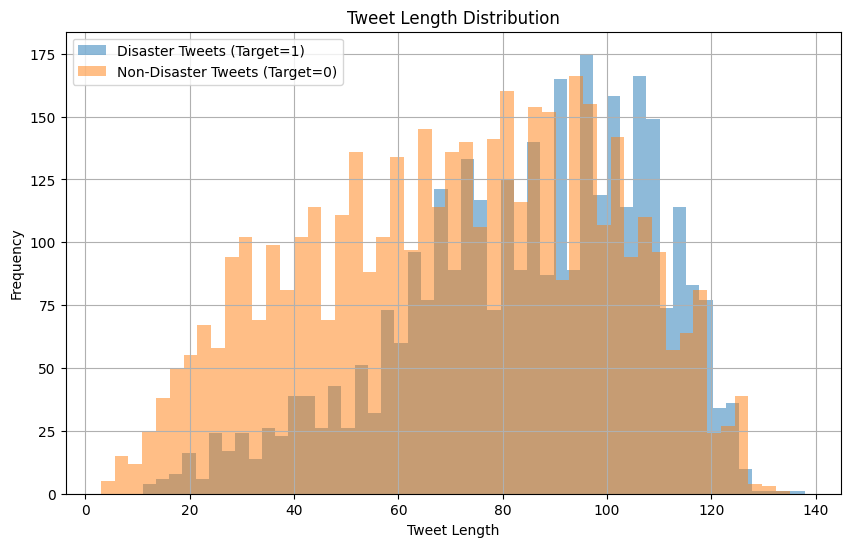

In [12]:
import matplotlib.pyplot as plt

disaster_tweet_lengths = train_df[train_df["target"] == 1]["cleaned_text"].str.len()
non_disaster_tweet_lengths = train_df[train_df["target"] == 0]["cleaned_text"].str.len()

print(f"Number of disaster tweets: {len(disaster_tweet_lengths)}")
print(f"Number of non-disaster tweets: {len(non_disaster_tweet_lengths)}")

plt.figure(figsize=(10, 6))

plt.hist(
    disaster_tweet_lengths,
    bins=50,
    alpha=0.5,
    label="Disaster Tweets (Target=1)",
)
plt.hist(
    non_disaster_tweet_lengths,
    bins=50,
    alpha=0.5,
    label="Non-Disaster Tweets (Target=0)",
)

plt.title("Tweet Length Distribution")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

Looking at a word cloud, we notice significant overlap in vocabulary between the two target classes. However, there are also some words that appear to be unique to each class.

To better understand these distinctions, we can follow up with topic modeling using Latent Dirichlet Allocation (LDA) to highlight the underlying differences more clearly.

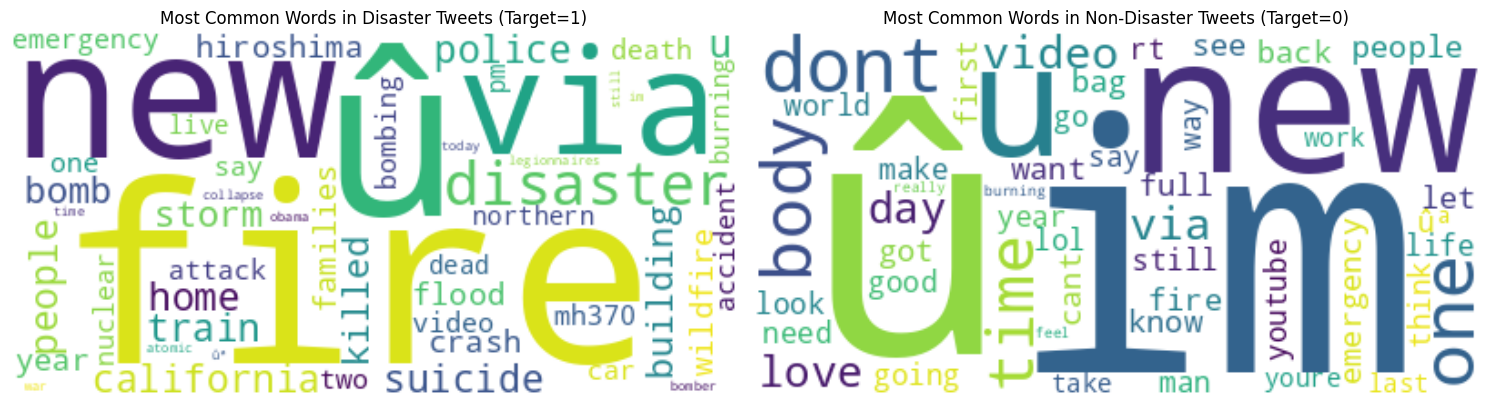

In [13]:
from wordcloud import WordCloud

disaster_tweets = train_df[train_df["target"] == 1]["cleaned_text"]
non_disaster_tweets = train_df[train_df["target"] == 0]["cleaned_text"]

disaster_text = " ".join(disaster_tweets)
wordcloud_disaster = WordCloud(
    max_words=50, background_color="white", collocations=False
).generate(disaster_text)

non_disaster_text = " ".join(non_disaster_tweets)
wordcloud_non_disaster = WordCloud(
    max_words=50, background_color="white", collocations=False
).generate(non_disaster_text)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(wordcloud_disaster, interpolation="bilinear")
axes[0].set_title("Most Common Words in Disaster Tweets (Target=1)")
axes[0].axis("off")

axes[1].imshow(wordcloud_non_disaster, interpolation="bilinear")
axes[1].set_title("Most Common Words in Non-Disaster Tweets (Target=0)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

disaster_tweets_cleaned = train_df[train_df["target"] == 1]["cleaned_text"]
non_disaster_tweets_cleaned = train_df[train_df["target"] == 0]["cleaned_text"]


def perform_lda(text_series, title, n_topics=5, n_top_words=10):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
    dtm = vectorizer.fit_transform(text_series)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    print(f"\n--- {title} Topics ---")
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
            )
        )


perform_lda(disaster_tweets_cleaned, "Disaster Tweets (Target=1)")
perform_lda(non_disaster_tweets_cleaned, "Non-Disaster Tweets (Target=0)")


--- Disaster Tweets (Target=1) Topics ---
Topic #1:
emergency buildings accident im burning train man airplane sinkhole city
Topic #2:
years hiroshima today atomic war 70 storm heat deaths people
Topic #3:
video severe nuclear disaster mh370 debris thunderstorm migrants news rescuers
Topic #4:
suicide bombing bomber disaster obama bomb killed dead wreckage pm
Topic #5:
california like wildfire fires legionnaires families news northern latest watch

--- Non-Disaster Tweets (Target=0) Topics ---
Topic #1:
like im new got loud sinking news people bang life
Topic #2:
youtube video liked destroyed body bagging light new crash market
Topic #3:
dont reddit like day ill im quarantine blew think screams
Topic #4:
like dont emergency know new im youre burning want man
Topic #5:
im body like wreck cross bags day bag best new


## Summary

The EDA section revealed several key insights:

- **Data completeness**: The `location` and `keyword` features contain many missing values.
- **Target imbalance**: There are more tweets not related to disasters, and tweets about real disasters tend to be longer.
- **Lexical overlap**: While both classes share many of the same words, there are distinctive words and phrases that differentiate disaster-related tweets from others.
- **Preprocessing**: The text includes stopwords, punctuation, and other non-informative tokens that can be removed to improve analysis.

These findings suggest that the most useful signal comes from the specific phrases used in the tweet text. As a result, we should prioritize models that can capture phrase-level semantics. We should also consider techniques for handling class imbalance, such as resampling or adjusting class weights in the loss function. Given the sparsity of the `location` and `keyword` fields, it's reasonable to exclude them from the initial model rather than applying imputation.

## Model Architecture

Models that can effectively capture phrases include LSTM, GRU, and more advanced transformer-based architectures like BERT. For this project, we'll begin by focusing on building the most performant LSTM model possible as a strong baseline.

### LSTM

To get started, we'll build a standard LSTM model using Keras. In addition to the preprocessing steps outlined earlier, we need to tokenize the words so they can be used as input to the model. We'll also pad the token sequences to ensure all samples have the same length, which improves training efficiency.

To make informed choices for the tokenizer vocabulary size and the padding sequence length, we'll perform one additional step of EDA to analyze word frequency and sequence length distribution.

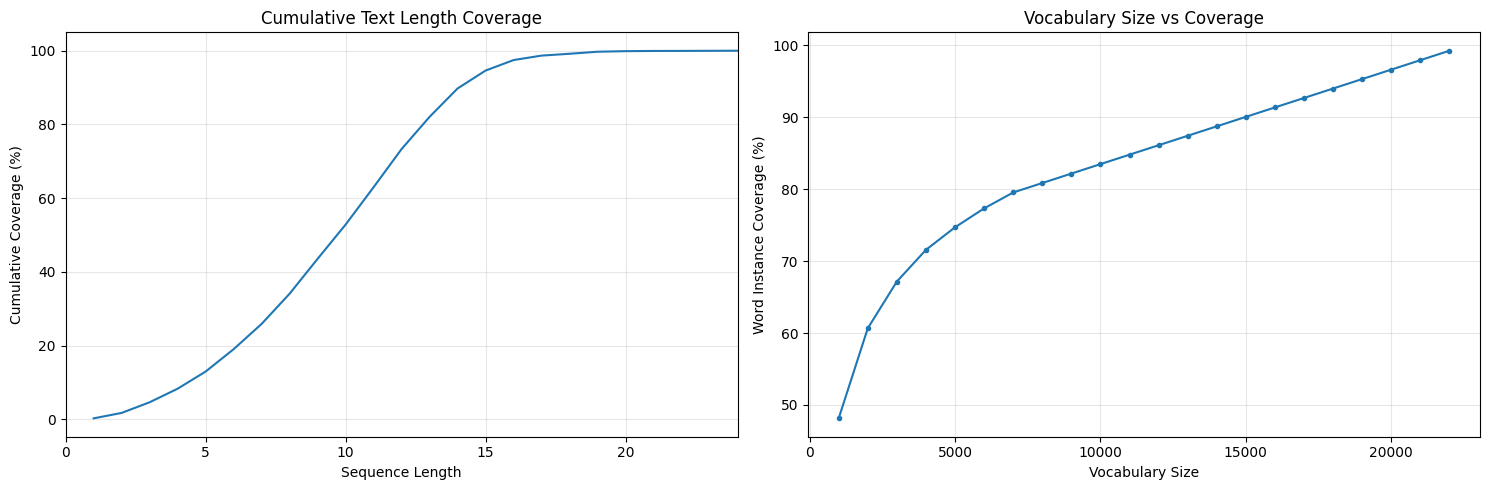

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer


texts = train_df["cleaned_text"].values
word_counts = [len(text.split()) for text in texts]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_freq = tokenizer.word_counts
total_word_instances = sum(word_freq.values())
total_words = len(word_freq)
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
word_counts_array = np.array(word_counts)
max_length = min(max(word_counts), 500)
cumulative_coverage = np.array(
    [
        sum(word_counts_array <= length) / len(word_counts_array) * 100
        for length in range(1, max_length + 1)
    ]
)

axes[0].plot(range(1, len(cumulative_coverage) + 1), cumulative_coverage)
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Cumulative Coverage (%)")
axes[0].set_title("Cumulative Text Length Coverage")
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, max_length)

vocab_sizes = list(range(1000, min(30000, total_words), 1000))
coverage_percentages = []
for size in vocab_sizes:
    coverage = (
        sum([freq for word, freq in sorted_words[:size]]) / total_word_instances * 100
    )
    coverage_percentages.append(coverage)

axes[1].plot(vocab_sizes, coverage_percentages, marker="o", markersize=3)
axes[1].set_xlabel("Vocabulary Size")
axes[1].set_ylabel("Word Instance Coverage (%)")
axes[1].set_title("Vocabulary Size vs Coverage")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

It appears safe to use a vocabulary size of 15,000 to capture approximately 90% of the word variance, and a sequence length of 25 tokens for padding. These charts also highlight how text lengths shift after preprocessing, particularly due to stop word removal.

For the model itself (see `build_model`), we can explore different dropout rates and LSTM unit counts using a random search. A dense layer will be necessary at the end to convert the LSTM output into a binary classification prediction.

Trial 4 Complete [00h 01m 29s]
val_accuracy: 0.7905449867248535

Best val_accuracy So Far: 0.7971109747886658
Total elapsed time: 00h 04m 37s

Best hyperparameters:
LSTM Units: 64
Dropout Rate: 0.2

Training final model...
Epoch 1/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6515 - loss: 0.6211 - val_accuracy: 0.7984 - val_loss: 0.4458
Epoch 2/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8833 - loss: 0.2912 - val_accuracy: 0.7768 - val_loss: 0.4966
Epoch 3/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9399 - loss: 0.1726 - val_accuracy: 0.7617 - val_loss: 0.6156
Epoch 4/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9645 - loss: 0.1022 - val_accuracy: 0.7518 - val_loss: 0.6765
Epoch 5/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9788 - loss: 0.0674 - val_accuracy: 0.7393 - val_loss: 0.7463
Epoch 6/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9764 - loss: 0.0657 - val_accuracy: 0.7439 - val_loss: 0.8810
Epoch 

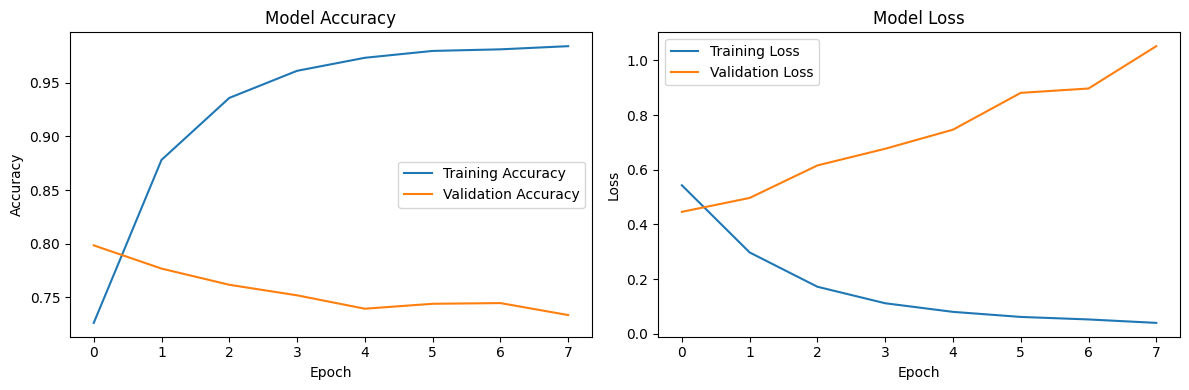

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras_tuner as kt

texts = train_df["cleaned_text"].values
labels = train_df["target"].values

max_words = 15000
tokenizer = Tokenizer(num_words=max_words, split=" ")
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)

max_sequence_length = 25
X = pad_sequences(X, maxlen=max_sequence_length)

X_train, X_val, y_train, y_val = train_test_split(
    X, labels, test_size=0.2, random_state=42
)


def build_model(hp):
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_sequence_length))
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3])
    model.add(SpatialDropout1D(dropout_rate))
    lstm_units = hp.Choice("lstm_units", [64, 128])
    model.add(LSTM(lstm_units))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=8,
)

print("\nStarting hyperparameter search...")
tuner.search(
    X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

print(f"\nBest hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print("\nTraining final model...")
history = best_model.fit(
    X_train, y_train, epochs=8, batch_size=32, validation_data=(X_val, y_val), verbose=1
)

loss, accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Results:")
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

def plot_history(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["accuracy"], label="Training Accuracy")
  plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
  plt.title("Model Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history["loss"], label="Training Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.title("Model Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_history(history)

As observed, the model performed reasonably well but showed signs of overfitting across all hyperparameter trials. Addressing overfitting is essential to achieve a reliable and accurate model within this architecture.

Several approaches can help mitigate overfitting:

- Increasing the dropout rate  
- Reducing the size of the LSTM layer  
- Implementing early stopping  
- Using a bidirectional LSTM  
- Incorporating pretrained embeddings  

We can start by experimenting with early stopping and increasing the dropout rate, as these are straightforward to implement. Given the relatively small dataset, leveraging pretrained embeddings may also provide meaningful improvements.

### Improving Performance with Early Stopping and Dropout Rate Tuning

Trial 8 Complete [00h 00m 57s]
val_accuracy: 0.7852922081947327

Best val_accuracy So Far: 0.8010505437850952
Total elapsed time: 00h 05m 35s

Best hyperparameters:
LSTM Units: 64
Dropout Rate: 0.3

Training final model with early stopping...
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6359 - loss: 0.6246 - val_accuracy: 0.7951 - val_loss: 0.4464
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8878 - loss: 0.2946 - val_accuracy: 0.7899 - val_loss: 0.4730
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9354 - loss: 0.1884 - val_accuracy: 0.7676 - val_loss: 0.5834

Final Results:
Validation Loss: 0.4464
Validation Accuracy: 0.7951


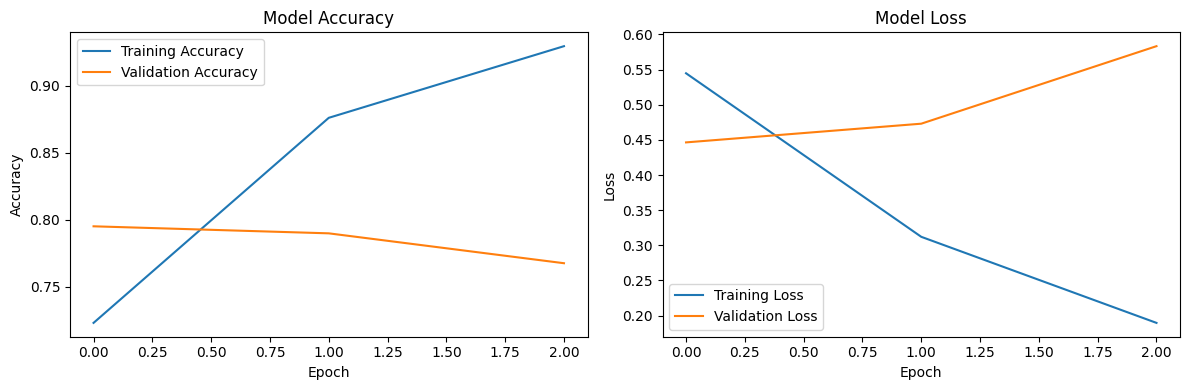

In [17]:
from tensorflow.keras.callbacks import EarlyStopping


def build_model_2(hp):
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_sequence_length))
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4, 0.5])
    model.add(SpatialDropout1D(dropout_rate))
    lstm_units = hp.Choice("lstm_units", [64, 128])
    model.add(LSTM(lstm_units))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


tuner = kt.RandomSearch(
    build_model_2, objective="val_accuracy", max_trials=8, overwrite=True
)

print("\nStarting hyperparameter search with early stopping...")

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
tuner.search(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

print(f"\nBest hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")

print("\nTraining final model with early stopping...")
history = best_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
)

loss, accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Results:")
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

plot_history(history)

Early stopping and dropout rate tuning have improved the model, but some overfitting remains. This is likely due to the small size of the dataset. Next, we will explore incorporating pretrained embeddings within the same model architecture to see if they can enhance performance.

### Improving Performance with Pretrained Word Embeddings

In [22]:
import numpy as np

embedding_dim = 100
embedding_index = {}

with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [23]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Trial 8 Complete [00h 00m 25s]
val_accuracy: 0.8115561604499817

Best val_accuracy So Far: 0.8154957294464111
Total elapsed time: 00h 06m 24s

Best hyperparameters:
LSTM Units: 64
Dropout Rate: 0.3

Training final model...
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7355 - loss: 0.5478 - val_accuracy: 0.7991 - val_loss: 0.4405
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7953 - loss: 0.4572 - val_accuracy: 0.8037 - val_loss: 0.4360
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7997 - loss: 0.4403 - val_accuracy: 0.8063 - val_loss: 0.4325
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8050 - loss: 0.4362 - val_accuracy: 0.8116 - val_loss: 0.4295
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8128 - loss: 0.4273 - val_accuracy: 0.8109 - val_loss: 0.4241
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8183 - loss: 0.4221 - val_accuracy: 0.8162 - val_loss: 0.4273
Epo

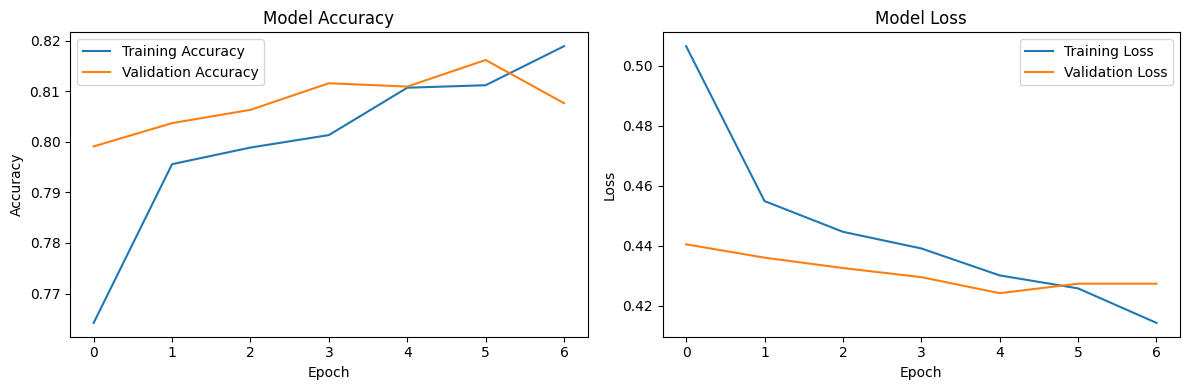

In [24]:
def build_model_3(hp):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=max_words,
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=False,
        )
    )
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4, 0.5])
    model.add(SpatialDropout1D(dropout_rate))
    lstm_units = hp.Choice("lstm_units", [64, 128])
    model.add(LSTM(lstm_units))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


tuner = kt.RandomSearch(
    build_model_3, objective="val_accuracy", max_trials=8, overwrite=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

print("\nTuning model with GloVe embeddings...")
tuner.search(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

print(f"\nBest hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")

print("\nTraining final model...")
history = best_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
)

loss, accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Results:")
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

plot_history(history)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


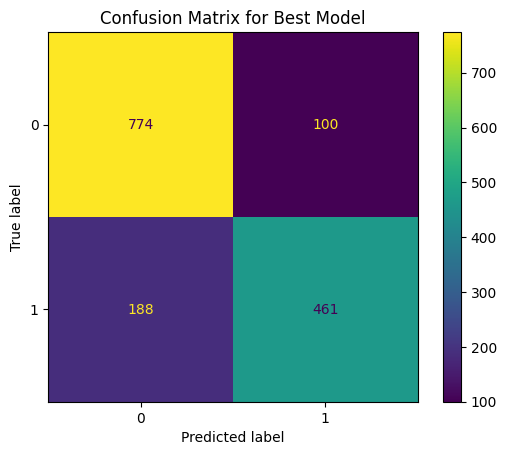

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = best_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for Best Model")
plt.show()

Using pretrained word embeddings proved highly advantageous and significantly reduced the overfitting issue.

There are additional steps we could take to further improve model performance, but this feels like a good stopping point given what we’ve learned throughout the project. Next, we will generate our submission, ensuring the preprocessing pipeline is applied consistently to the test data.

In [25]:
test_texts = test_df["text"].apply(clean_text).values

X_test = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

predictions = best_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

submission_df = pd.DataFrame({"id": test_df["id"], "target": predictions.flatten()})
submission_df.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Submission file created: submission.csv


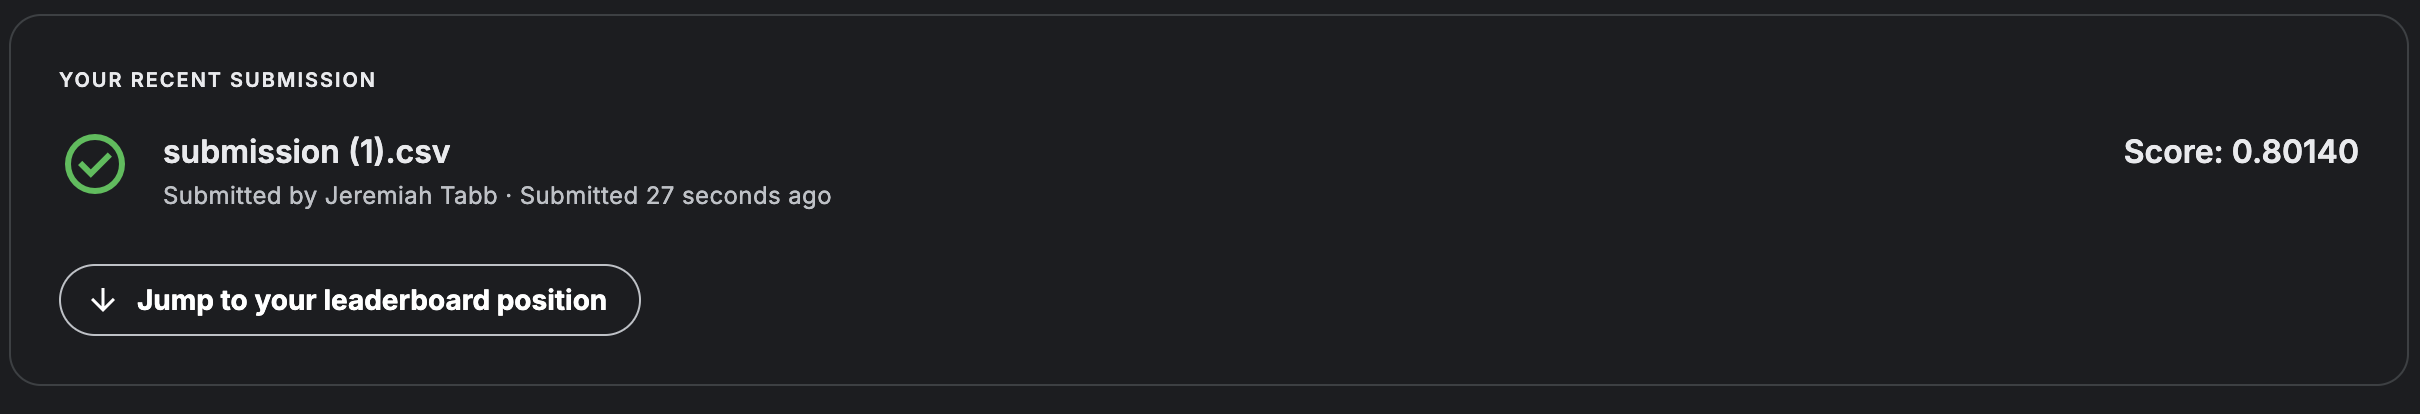

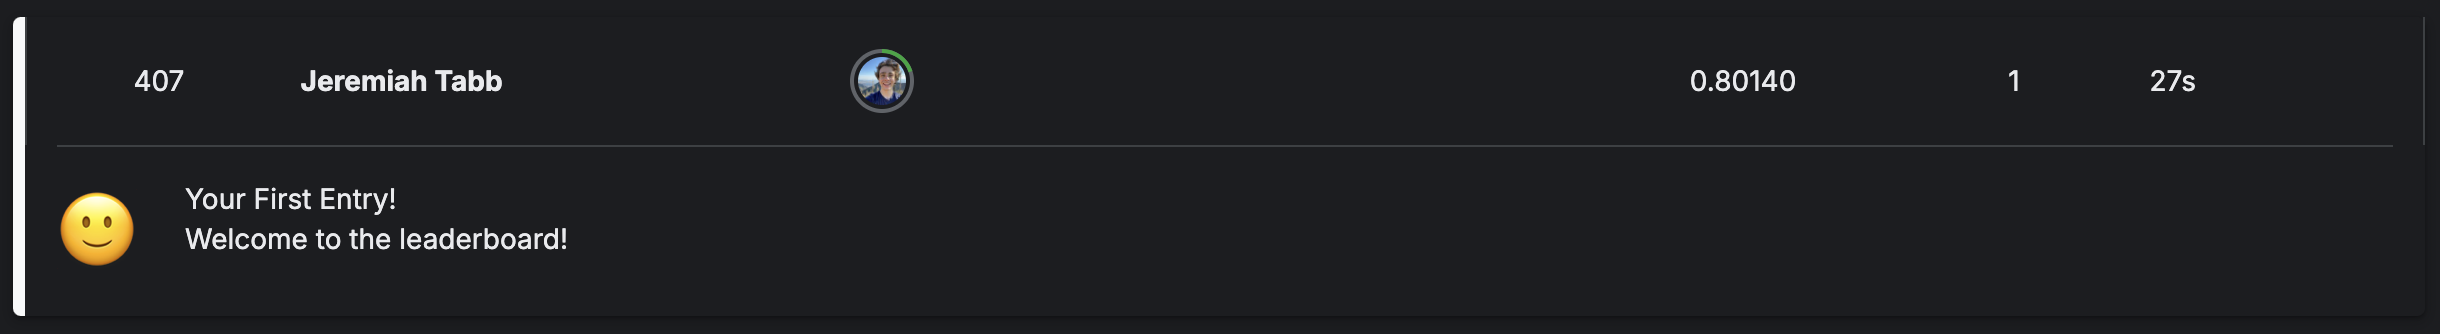

## Results and Analysis

Most of my analysis can be found in the markdown blocks between model iterations.

Our final LSTM model, improved with **pretrained word embeddings** and refined using **early stopping and dropout**, showed significantly better generalization. The embeddings were crucial for handling our limited dataset size, providing richer semantic context that drastically reduced overfitting.

Despite these gains, some overfitting remained, highlighting the inherent challenges of a small, noisy dataset. The imbalance between disaster and non-disaster tweets further complicated training; future work should explore advanced class imbalance techniques.

**Lexical analysis** confirmed that **phrase-level distinctions** in tweet text are the most informative classification features, validating our choice of **sequence models** like LSTM. Conversely, location and keyword fields proved sparse and noisy, limiting their utility without imputation or augmentation.

## Conclusion

Our experiments revealed several key insights:

### What helped performance:

* **Pretrained embeddings:** These were by far the most impactful. They dramatically cut down on overfitting and boosted generalization by giving our model a much richer understanding of language than our small dataset could offer alone.
* **Early stopping and dropout:** These regularization techniques were great for keeping overfitting in check and stabilizing training, leading to more consistent performance across different hyperparameter settings.
* **Focused preprocessing:** Cleaning the text – like stripping out stop words and punctuation – standardized our input and helped the model zero in on the really meaningful content.

### What didn't help, or had limited impact:

* **Using location and keyword features:** These simply didn't add much value. They were riddled with missing data and noise, proving unhelpful without significant extra preprocessing or imputation.
* **Prematurely increasing model complexity:** Trying to use larger LSTM layers or more complex architectures actually tended to worsen overfitting, given the size of our dataset.

### Future improvements to explore:

* **Tackling class imbalance:** Techniques such as SMOTE, focal loss, or balanced batch sampling could be critical for addressing the skewed distribution between disaster and non-disaster tweets.
* **Bidirectional and attention-based models:** Looking into bidirectional LSTMs or transformer architectures might allow us to better capture context and more nuanced phrase relationships.
* **Data augmentation:** Generating synthetic tweets or bringing in additional external datasets could be a good way to increase the diversity of our training data.
* **Smarter feature engineering:** We could investigate better ways to incorporate location, keyword, or temporal metadata, perhaps by embedding these features or using more advanced imputation methods.
* **Deeper hyperparameter optimization:** More exhaustive or automated tuning strategies, like Bayesian optimization, could uncover even better model configurations.